In [228]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
import pandas as pd
ct.use_fbs_defaults()

In [229]:
def set_subplot(ax, x_data, y_data, xlabel, ylabel, title, line_color='#120a8f', linewidth=1.5):
  line, = ax.plot(x_data, y_data, linestyle='-',
                  color=line_color, linewidth=linewidth)
  ax.set_xlabel(xlabel, fontsize=18)
  ax.set_ylabel(ylabel, fontsize=18)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=20)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=16)

  return line

In [230]:
def update(t, x, u, params):
  LG = params['LG']
  RG1 = params['RG1']
  CG = params['CG']
  RG2 = params['RG2']
  LB = params['LB']
  RB1 = params['RB1']
  CB = params['CB']
  RB2 = params['RB2']
  LK = params['LK']
  RK = params['RK']
  CK = params['CK']
  RCRL = params['RCRL']

  RE1 = RB2 / (RG2 + RB2)
  RE2 = RG2 / (RG2 + RB2)

  ILG, ILB, ILK, VCG, VCB, VCK = x
  DG, VB, DB, PCPL, VG = u

  DOT_ILG = - (RG1 / LG) * ILG - (1 / LG) * VCG + (VG / LG) * DG
  DOT_ILB = - (RB1 / LB) * ILB - (1 / LB) * VCB + (1 / LB) * (1 - DB) * VB
  DOT_ILK = - ((RK + RG2 * RE1) / LK) * ILK - (1 / LK) * \
      VCK + (RE1 / LK) * VCG + (RE2 / LK) * VCB
  DOT_VCG = (1 / CG) * ILG - ((1 - RE1)/(CG * RG2)) * VCG - \
      (RE1 / CG) * ILK + (RE2 / (RG2 * CG)) * VCB
  DOT_VCB = (1 / CB) * (1 - DB) * ILB - ((1 - RE2) / (RB2 * CB)) * \
      VCB - ((RG2 * RE1)/(RB2*CB)) * ILK + (RE1 / (RB2 * CB)) * VCG
  DOT_VCK = (1 / CK) * ILK - (1 / (RCRL * CK)) * VCK - (1 / CK) * (PCPL / VCK)

  DOT_X = [DOT_ILG, DOT_ILB, DOT_ILK, DOT_VCG, DOT_VCB, DOT_VCK]

  return np.array(DOT_X)


def output(t, x, u, params):
  return x


system = ct.ss(update, output, name='microgrid',
               inputs=('DG', 'VB', 'DB', 'PCPL', 'VG'),
               states=('ILG', 'ILB', 'ILK', 'VCG', 'VCB', 'VCK'),
               outputs=('ILG', 'ILB', 'ILK', 'VCG', 'VCB', 'VCK'))

print(system)

<NonlinearIOSystem>: microgrid
Inputs (5): ['DG', 'VB', 'DB', 'PCPL', 'VG']
Outputs (6): ['ILG', 'ILB', 'ILK', 'VCG', 'VCB', 'VCK']
States (6): ['ILG', 'ILB', 'ILK', 'VCG', 'VCB', 'VCK']

Update: <function update at 0x7c5702026b00>
Output: <function output at 0x7c5701a60670>


In [231]:
params = {
    # Parâmetros da Geração
    'LG': 1e-3,
    'RG1': 0.1,
    'CG': 2.2e-3,
    'RG2': 0.1,

    # Parâmetros da Bateria
    'LB': 1e-3,
    'RB1': 0.1,
    'CB': 2.2e-3,
    'RB2': 0.1,

    # Parâmetros da Carga
    'LK': 1e-3,
    'RK': 0.1,
    'CK': 2.2e-3,
    'RCRL': 20,

    'OP': {
        'VB': 12,
        'VG': 48,
        'VCG': 24,
        'VCB': 24,
        'VCK': 20,
        'PCPL': 50
    }
}

LG = params['LG']
RG1 = params['RG1']
CG = params['CG']
RG2 = params['RG2']
LB = params['LB']
RB1 = params['RB1']
CB = params['CB']
RB2 = params['RB2']
LK = params['LK']
RK = params['RK']
CK = params['CK']
RCRL = params['RCRL']

RE1 = RB2 / (RG2 + RB2)
RE2 = RG2 / (RG2 + RB2)

OP = params['OP']

ILK_O = OP['VCK'] / RCRL + OP['PCPL'] / OP['VCK']

b = (OP['VCB'] / OP['VB'] - 2)
c = (- RB1 / OP['VB']) * (((1 - RE2) / RB2) * OP['VCB'] +
                          ((RG2 * RE1) / RB2) * ILK_O - (RE1 / RB2) * OP['VCG'])

delta = b**2 - 4 * c
x1 = (-b + math.sqrt(delta)) / 2
x2 = (-b - math.sqrt(delta)) / 2
DB_O = max(x1, x2)
# DB_O = min(1., DB_O)

ILG_O = ((1 - RE1) / RG2) * OP['VCG'] + \
    RE1 * ILK_O - (RE2 / RG2) * OP['VCB']
ILB_O = ((1 - RE2) / (RB2 * (1 - DB_O))) * OP['VCB'] + ((RG2 * RE1) /
                                                        (RE2 * (1 - DB_O))) * ILK_O - (RE1 * OP['VCG']) / (RB2 * (1 - DB_O))
DG_O = RG1 / OP['VG'] * ILG_O + OP['VCG'] / OP['VG']

U = [DG_O, 28, DB_O, OP['PCPL'], OP['VG']]
X = 0.95 * np.array([ILG_O, ILB_O, ILK_O, OP['VCG'], OP['VCB'], OP['VCK']])
# end_time = 4.4e-3
end_time = 2e-1
step = 1e-5

# Instantes de tempo
timepts = np.arange(0, end_time + step, step)

In [232]:
t, y = ct.input_output_response(
    sys=system, T=timepts,
    U=U, X0=X, params=params,
)

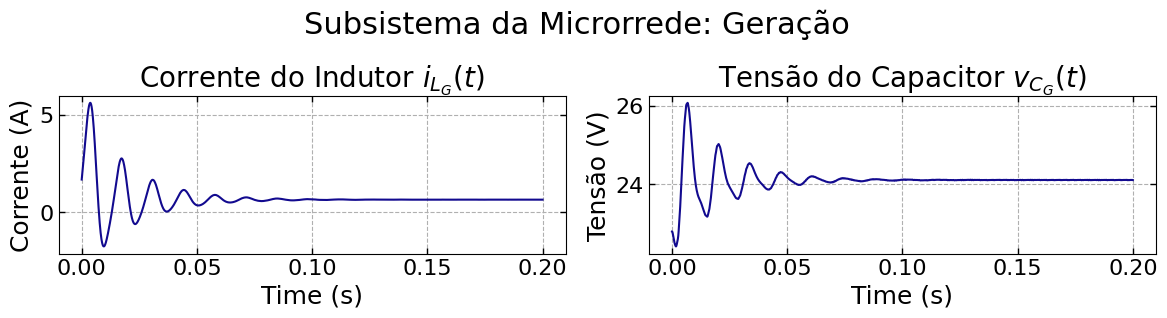

In [233]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Subsistema da Microrrede: Geração", fontsize=22)

set_subplot(
    axs[0], t, y[0],
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_G}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[3],
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_G}(t)$',
)

plt.tight_layout()

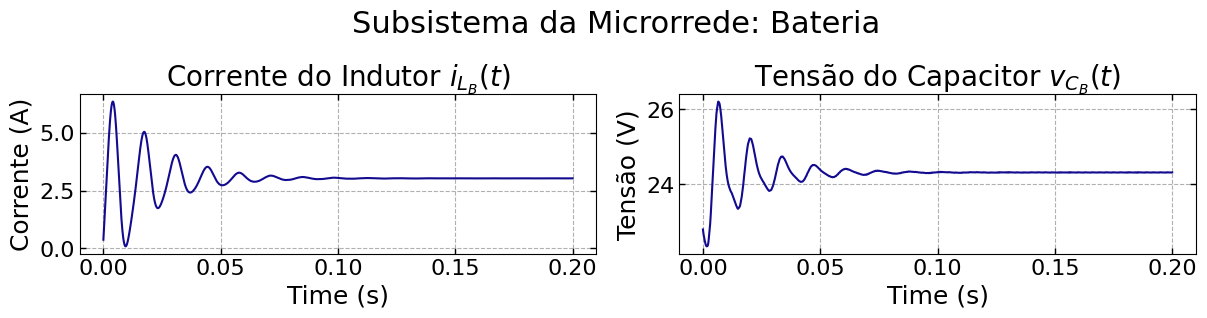

In [234]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Subsistema da Microrrede: Bateria", fontsize=22)

set_subplot(
    axs[0], t, y[1],
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_B}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[4],
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_B}(t)$',
)

plt.tight_layout()

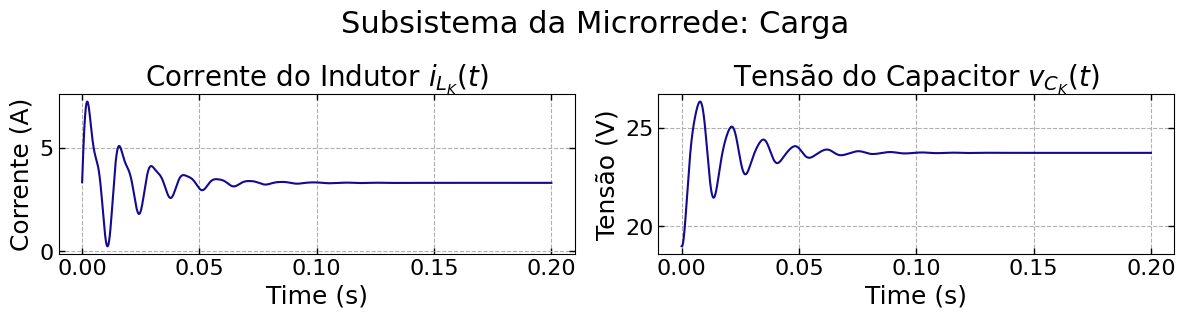

In [235]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Subsistema da Microrrede: Carga", fontsize=22)

set_subplot(
    axs[0], t, y[2],
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_K}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[5],
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_K}(t)$',
)

plt.tight_layout()

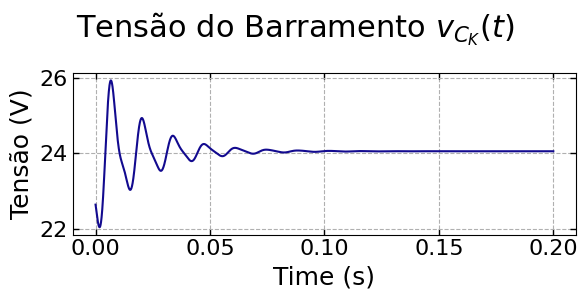

In [236]:
# Tensão do Barramento
VE = - RG2 * RE1 * y[2] + RE1 * y[3] + RE2 * y[4]

# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 1, figsize=(6, 3))

# Adicionando o título à figura
fig.suptitle("Tensão do Barramento $v_{C_K}(t)$", fontsize=22)

# set_subplot(
#     axs[0], t, y[2],
#     'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_K}(t)$',
# )

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs,  t, VE,
    'Time (s)', 'Tensão (V)', '',
)

plt.tight_layout()